In [15]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Application de la prédiction conforme à un problème de classification

On va créer un classifieur sur MNIST

## Données

In [2]:
n_epochs = 1
batch_size_train = 64
batch_size_calib = 1000
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

C:\Users\w\AppData\Roaming\Python\Python39\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


On dispose de beaucoup de données, on peut donc se permettre une SCP. Par contre, ce que l'on peut se permettre aussi, c'est de prélever l'ensemble de calibration sur l'ensemble de test.

In [4]:
calib_test = enumerate(test_loader)
batch_idx, (calib_data, calib_targets) = next(calib_test)
batch_idx, (test_data, test_targets) = next(calib_test)

## Modèle
On crée un réseau de neurone (alors je me suis pas embêté, je l'ai pris sur internet) qui classifie nos images. On notera que la sortie de ce réseau est un log_softmax: c'est bien car nous voulons les probas d'appartenance à chaque classe, par contre attention, c'est $\log(\mathbb P[x\in \mathcal{C}])$. Pour récupérer la probas, il faut passer à l'exp.

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [6]:
network = Net()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [7]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [8]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
          train_losses.append(loss.item())
          train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [9]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

In [10]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

C:\Users\w\Anaconda3\envs\gpu2\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
C:\Users\w\AppData\Local\Temp\ipykernel_8872\161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
C:\Users\w\Anaconda3\envs\gpu2\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3136, Accuracy: 544/10000 (5%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.367435
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.194901
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.938292
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.630961
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.241965
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.255797
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.017301
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.095071
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.950059
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.856249
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.696505
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.843235
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.738703
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.758076
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.517234
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.861259
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.646062
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.581119
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.719031
Train Epoch: 1 [12160/6

On a une accuracy de 96%. En soit on s'en fiche un peu, j'aurais presque préféré que ce soit moins bien que cela!

## La prédiction conforme (eeeeeenfin)

On défini notre fonction score : on ordonner les probas dans l'ordre décroissant, puis on les sommes tant que l'on est pas tombé sur le véritable label (que l'on inclus)

In [11]:
def score(data,truth):
    s = 0
    # Je crée les probas d'appartenance
    probs = torch.exp(network(data)[0]).detach().numpy()
    #Je crée les labels
    labels = np.arange(10)
    # Je crée les index des labels par ordre décroissant de probas
    idx = np.argsort(probs)[::-1]
    i=0
    #Mon test doit automatiquement passer la première étape!
    test = -1
    while int(truth) != int(test):
        #Si mon test précédent n'était pas le vrai label, j'additionne la probas suivante.
        s += probs[idx[i]]
        test = labels[idx[i]]
        i += 1
    return s

On crée une fonction de calibration pour la SCP qui ne s'applique que sur les données de calibrations. Cette fonction calcule tous les scores de conformités des données de calibrations, et en extrait le quantile $1-\alpha$

In [12]:
def calibration(calib_data,calib_targets,alpha):
    S = np.empty(calib_data.shape[0])
    for i in np.arange(calib_data.shape[0]):
        S[i] = score(calib_data[i:i+1],calib_targets[i])
    return np.quantile(S,1-alpha)

In [69]:
q_hat = calibration(calib_data,calib_targets,alpha = 0.1)

C:\Users\w\AppData\Local\Temp\ipykernel_8872\161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Je crée une fonction qui produit les ensemble de prédictions de chaque entrées avec les probas associées.

In [46]:
def ens_pred(x,q_hat):
    probs = torch.exp(network(x)[0]).detach().numpy()
    labels = np.arange(10)
    idx = np.argsort(probs)[::-1]
    p = 0
    i = 0
    ens = {}
    while p<q_hat:
        ens[labels[idx[i]]] = probs[idx[i]]
        p += probs[idx[i]]
        i += 1
    return ens

C:\Users\w\AppData\Local\Temp\ipykernel_8872\161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


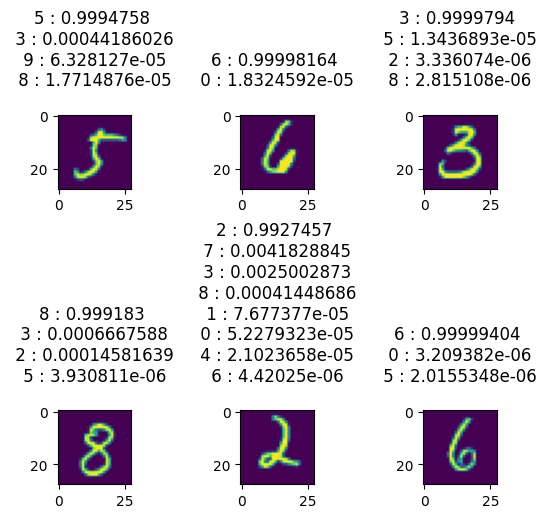

In [74]:
idx = np.random.randint(0,1000,size = 6)
test = test_data[idx]
fig, axs = plt.subplots(2,3)
plt.subplots_adjust(wspace=0.4, 
                    hspace=3)
for row in range(2):
    for col in range(3):
        ens = ens_pred(test[row*3+col:row*3+col+1],q_hat)
        title = "".join([str(key)+' : '+str(ens[key])+' \n ' for key in ens.keys()])
        axs[row,col].imshow(test[row*3+col,0])
        axs[row,col].set_title(title)

C'est pas si mal hein? A première vue, les sorties dans l'ansemble de prédiction sont plutôt cohérentes!